# Building an image classifier

We're going to use a pretrained model to classify images into certain buckets.

First thing's first, lets find a dataset.

In [1]:
from pathlib import Path
from zipfile import ZipFile

In [2]:
if Path("./vegetable-image-dataset.zip").is_file():
    print("The dataset is already downloaded.")
else:
    !kaggle datasets download -d misrakahmed/vegetable-image-dataset
    print("The dataset is downloaded.")

if Path("./Vegetable Images").is_dir():
    print("The dataset is already extracted.")
else:
    with ZipFile("./vegetable-image-dataset.zip", "r") as zipObj:
        zipObj.extractall()
        print("The dataset is extracted.")

The dataset is already downloaded.
The dataset is already extracted.


This vegetable dataset [[ref](https://www.kaggle.com/datasets/misrakahmed/vegetable-image-dataset)] contains 
* 21000 images from 15 classes, 
  * where each class contains a total of 1400 images. 
* Each class has an equal proportion and image resolution is 224×224 and in *.jpg format. 
* We split our dataset into three parts, where 70%(approx.) for training and 15%(approx.) for testing, and the rest 15%(approx.) for validation.

In [3]:
from fastai.vision.all import *

Let's have a sneak peak at an image of a bean


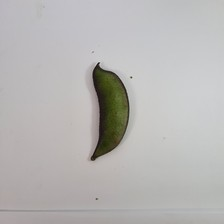

In [4]:
im = Image.open('Vegetable Images/train/Bean/0026.jpg')
print("Let's have a sneak peak at an image of a bean")
im.to_thumb(256,256)

In [5]:
# create a dataframe with all the images path and their labels
df = pd.DataFrame(columns=['image_path', 'label'])
for folder in os.listdir('Vegetable Images/train'):
    for file in os.listdir(f'Vegetable Images/train/{folder}'):
        df = pd.concat(
            [df, pd.DataFrame({
                'image_path': [f'Vegetable Images/train/{folder}/{file}'], 
                'label': [folder]
                })
            ], 
            ignore_index=True
        )

In [6]:
df.head()

,image_path,label
0,Vegetable Images/train/Capsicum/0071.jpg,Capsicum
1,Vegetable Images/train/Capsicum/0717.jpg,Capsicum
2,Vegetable Images/train/Capsicum/0703.jpg,Capsicum
3,Vegetable Images/train/Capsicum/0065.jpg,Capsicum
4,Vegetable Images/train/Capsicum/0059.jpg,Capsicum


In [7]:
print(f"""
Training data set contains {df.shape[0]:,} image
Representing {round(df.shape[0]*100/21000)}% of the total dataset
Across {df.label.nunique()} classes
""")


Training data set contains 15,000 image
Representing 71% of the total dataset
Across 15 classes



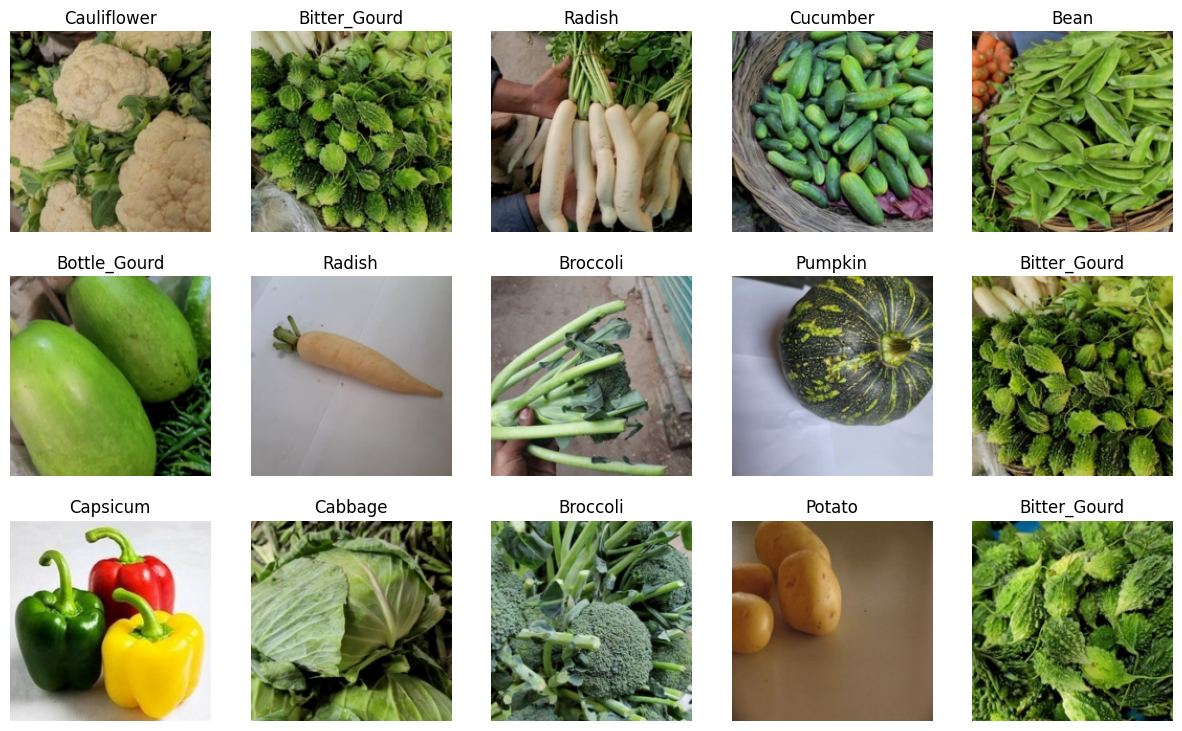

In [8]:
path = Path("Vegetable Images/train")

dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,  # this is super clever, it will get the parent folder name as the label
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=15)

In [9]:
learn = vision_learner(
    dls, 
    resnet18, 
    metrics=error_rate, 
)
learn.fine_tune(2)

# resent18 in the nn architecture we're using
# it is essentially a template, with pre-trained weights
# we need to provide values for the millions of parameters it contains
# fine-tuning is the process of updating these parameters to fit our dataset

/Users/michael/Library/Caches/pypoetry/virtualenvs/practical-deep-learning-e9QnJ1bO-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/michael/Library/Caches/pypoetry/virtualenvs/practical-deep-learning-e9QnJ1bO-py3.10/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.138384,0.034108,0.009000,09:31


epoch,train_loss,valid_loss,error_rate,time


In [ ]:
# test set
# create a dataframe with all the images path and their labels
test_df = pd.DataFrame(columns=['image_path', 'label'])
for folder in os.listdir('Vegetable Images/test'):
    for file in os.listdir(f'Vegetable Images/test/{folder}'):
        test_df = pd.concat(
            [test_df, pd.DataFrame({
                'image_path': [f'Vegetable Images/test/{folder}/{file}'], 
                'label': [folder]
                })
            ], 
            ignore_index=True
        )

In [ ]:
%%capture --no-display
# _predictions = []
# _confidences = []

# for i, row in test_df.iterrows():
#     img = PILImage.create(row['image_path'])
#     pred_class, pred_idx, probs = learn.predict(img)
#     _predictions.append(pred_class) # test_df.loc[i, 'prediction'] = pred_class
#     _confidences.append(probs[pred_idx].item()) # test_df.loc[i, 'prediction_confidence'] = probs[pred_idx].item()

# test_df = test_df.assign(
#     prediction=_predictions, 
#     prediction_confidence=_confidences,
#     is_model_correct=lambda x: x['label'] == x['prediction']
# );

_results = [learn.predict(PILImage.create(i)) for i in test_df.image_path.values]

In [ ]:
test_df = test_df.assign(
    prediction=[i[0] for i in _results],
    prediction_confidence=[i[2][i[1]].item() for i in _results],
    is_model_correct=lambda x: x['label'] == x['prediction']
)

test_df.head()

In [ ]:
print(f"{round(sum(test_df.is_model_correct) / test_df.shape[0], 2)}% of the test set was correctly classified")

In [ ]:
label, idx, probs = learn.predict('Vegetable Images/validation/Bean/0023.jpg')  # returns, string, integer and probabilities
print(f"This is a: {a}.")
print(f"Probability it's a {a}: {probs[idx]:.4f}")

In [ ]:
learn.show_results()

In [ ]:
#TODO: try an image classifier on whoop workouts

## Lecture & book notes

Classic ML approach to image recognition was to develop very sophisticated features (sometimes thousands). These features were then fed into a model (could be logistic regression). This was common place in 2012, and could be very successful in a single, confined domain, but tooks lots of people and lots of time (we're talking years).

Neural networks build this features for us. We don't give it features, we ask it to learn features.

In 2015 Zeiler and Fergus looked into a neural network to see what it had learned and saw it had learned edges. These were considered "layer 1 features".

Deep learning is deep because it can take these features and combine them to develop more advanced features.

In layer 2 features, we can start to see corners, circles, et cetera.

The deeper you go, the more sophiticated the features become.

This is the big breaktrhough, features are learnt not coded. Feature engineering still may have a place in some use cases (I think tabular data for example). Sounds and time-series data have been turnded into images and then you can run classifiers on them. Be creative in the problem you're trying to solve. These models are more generalisable than you think.

A lot of the need to tweak neaural network architectures is no longer required, unless you're on the bleeding edge. A lot of the deep learning community has agreed on a set of core models that generally work. `fastai` provides a lot of these "out of the box". The main thing you often need to work out is how to get data into your model.

In `fastai`'s `DataBlock`  they looked at the things that change most between projects to get data into the right shape.

```Python
DataBlock(
    blocks=(
        ImageBlock,  # what kind of input do we have
        CategoryBlock  # what kind of output is there
    ), 
    get_items=get_image_files,   # what are the items in this model, what am i going to train on - get_image_files is a function that returns a list of all the training images
    splitter=RandomSplitter(valid_pct=0.2, seed=42),  # this generates a validation set
    get_y=parent_label,  # get_y is the correct labels, parent_label is a function that returns the parent directory as the label
    item_tfms=[Resize(192, method='squish')]  # most computer vision architectures need all images to be the same size
).dataloaders(path)
```

In `fastai` a `learner` is a model (the neural network function) and the data we use to train it with.

```Python
learn = vision_learner(
    dls,  # data
    resnet18,   # model - there are a relatively small number that generally work, fastai downloads the generally accepted best practice weights for the model selected
    metrics=error_rate
)
```

For tabluar data, we say `fit_one_cycle` rather than `fine_tune` as there is unlikely to be an existing model.



In [ ]:
# def setup_colab():
#     "Sets up Colab. First run `!pip install -Uqq fastbook` in a cell"
#     assert IN_COLAB, "You do not appear to be running in Colab"
#     global gdrive
#     gdrive = Path('/content/gdrive/My Drive')
#     from google.colab import drive
#     if not gdrive.exists(): drive.mount(str(gdrive.parent))